In [2]:
'''
Create a SLP project using labeled frames from from Label3D - posture net model
----------------------------------------------------
Takes labeled data from Label3D and reformats into 2D labels and frames.

Currently crops around the bird by finding the center of the labeled body points,
rather than using the comNet prediction as in SC's CreateDataset function.

Will need to use the comNet prediction for cropping unlabeled images for prediction.

Then, reformats the labels and images to create a SLP project.
'''
import numpy as np
import matplotlib.pyplot as plt
import csv
import mat73
import os
import sys
sys.path.append("C:/Users/User/Documents/GitHub/poseTrackingXL/utils")
from slp_utils_XL import create_slp_project, crop_from_com
sys.path.append("../camera_calibration/")
import pySBA

ModuleNotFoundError: No module named 'sleap'

In [2]:
''' ADJUST PARAMS AND PATHS AS NEEDED '''
''' cropping params '''
w3d = 0.25 # scaling factor # originally 0.25, but DA's coordinate system is 400x larger
crop_size = (320, 320) # pixels - may need to adjust

In [3]:
''' set paths '''
proj_date = "allIL_081425"
skeleton_file = 'C:/Users/User/Documents/GitHub/poseTrackingXL/postureNet/posture_skeleton_IL.csv'
# to save SLP project
slp_project_dir = 'Z:/Sherry/poseTrackingXL/training_files/SLP/'
slp_project_file = f'{proj_date}_posture_net.slp'
slp_project_path = f'{slp_project_dir}{slp_project_file}'
# to save training images
training_vid_dir = 'Z:/Sherry/poseTrackingXL/training_files/posture_vids/'
vid_file = f'{proj_date}_posture_vid.npy'
training_vid_path = f'{training_vid_dir}{vid_file}'

In [4]:
# Label3D training data
training_dir = 'Z:/Sherry/poseTrackingXL/training_files/Label3D/'
training_files = []
for f in os.listdir(training_dir):
    if 'manual' in f: # "manual" are from IL
        training_files.append(f)
training_files, len(training_files)

(['ROS50_240910_manual_videos.mat',
  'LIM63_240610_mistakes_manual_videos.mat',
  'SLV124_240906_mistakes_manual_videos.mat',
  'AMB104_240903_manual_videos.mat',
  'RBY92_250620_manual_videos.mat',
  'SLV124_240906_manual_inferred_adj_videos.mat',
  'EMR53_240913_manual_videos.mat',
  'AMB153_250709_manual_videos.mat',
  'SLV124_240906_manual_inferred_videos.mat',
  'SLV132_250303_mistakes_manual_videos.mat',
  'SLV132_250310_mistakes_manual_videos.mat',
  'PRL72_250619_manual_videos.mat',
  'ROS105_241104_manual_videos.mat',
  'PRL72_250616_manual_videos.mat'],
 14)

In [5]:
''' Functions '''
def formatData(data3D):
    nFrames = data3D.shape[0]
    nParts = data3D.shape[1]//3
    data3D = np.reshape(data3D, (nFrames, nParts, 3)) # reshape the data
    return (data3D, nFrames, nParts)

In [6]:
def avgBody(pt3d, body_idx=np.asarray([4, 5, 8, 12])):
    '''
    given a set of 3d points (shape (n_frames, n_parts, 3))
    averages across the body parts to get the rough centroid

    default body_idx = [4, 5, 8, 12]
    - center back, base tail, left wing, right wing
    '''
    return np.mean(pt3d[:, body_idx], axis=1)

In [7]:
def projectData(matfile):
    '''
    takes in a matfile from Label3D which contains
    - camera params
    - 3D point locations
    reshapes 3D data to (n_frames, n_nodes, 3)
    finds the scale to crop each frame around the bird
    reprojects onto each camera view to get an array of shape (n_frames, n_cams, n_nodes, 2)
    '''

    camParams = pySBA.convertParams(matfile['camParams'])
    pt3d, nFrames, nParts = formatData(matfile['data_3D'])
    sba = pySBA.PySBA(camParams, np.NaN, np.NaN, np.NaN, np.NaN)
    nCams = camParams.shape[0]
    allCamScales = np.full((nFrames,nCams), np.NaN)
    allLabels = np.full((nFrames, nCams, nParts, 2), np.NaN)
    allCentroids = np.full((nFrames, nCams, 2), np.NaN)
    for nCam in range(nCams):
        # get the scales for this camera
        rot_vec = camParams[nCam][:3].reshape((1, 3))
        trans_vec = camParams[nCam][3:6]
        focal_l = camParams[nCam][6]
        pt3d_centroid = np.mean(pt3d, axis=1) # average over parts
        pt3d_centroid = sba.rotate(pt3d_centroid, np.tile(rot_vec, (nFrames, 1))) # rotate to camera coordinates
        camDist = pt3d_centroid[:, 2] + trans_vec[2] # get z-axis distance ie along optical axis
        camScale = focal_l / camDist # convert to focal length divided by distance
        allCamScales[:, nCam] = camScale

        # get the labels
        for nPart in range(nParts):
            allLabels[:, nCam, nPart, :] = sba.project(pt3d[:, nPart], np.tile(camParams[nCam], (nFrames,1)))

        # get the body centroids
        body_ctr = avgBody(pt3d)
        allCentroids[:, nCam, :] = sba.project(body_ctr, np.tile(camParams[nCam], (nFrames,1)))

    return allLabels, allCamScales, allCentroids

In [10]:
''' Reformat 3D points from Label3D into an array of 2D points '''
# get the 2D points and frames for each Label3D file
# also get the body centroids and camera scales
all_labels = [] # (n_frames, n_cams, n_nodes, 2)
all_images = [] # list (len (n_cams,)) of arrays (w, h, n_frames)
all_scales = [] # (n_frames, n_cams)
all_centroids = [] # (n_frames, n_cams, 2)
for fn in training_files:
    print(fn)
    file_path = f"{training_dir}{fn}"
    matfile = mat73.loadmat(file_path)
    labelled_idx = np.where(~np.isnan(matfile['data_3D']).any(axis=1))[0]
    labels, scales, centroids = projectData(matfile)
    labels = labels[labelled_idx,:]
    scales = scales[labelled_idx,:]
    centroids = centroids[labelled_idx,:]
    images = []
    for cam_idx in range(4):  # Loop through each camera
        video_data = np.array(matfile['videos'][cam_idx])
        tmp = video_data[..., labelled_idx]
        images.append(tmp)
    all_images.append(np.array(images))
    all_labels.append(np.array(labels))
    all_scales.append(np.array(scales))
    all_centroids.append(np.array(centroids))

for i in range(len(all_images)):
    if all_images[i].shape[4] == 1:
        all_images[i] = np.repeat(all_images[i], 3, axis=4)
    all_images[i] = np.squeeze(all_images[i], axis = 1)

ROS50_240910_manual_videos.mat
LIM63_240610_mistakes_manual_videos.mat
SLV124_240906_mistakes_manual_videos.mat
AMB104_240903_manual_videos.mat
RBY92_250620_manual_videos.mat
SLV124_240906_manual_inferred_adj_videos.mat
EMR53_240913_manual_videos.mat
AMB153_250709_manual_videos.mat
SLV124_240906_manual_inferred_videos.mat
SLV132_250303_mistakes_manual_videos.mat
SLV132_250310_mistakes_manual_videos.mat
PRL72_250619_manual_videos.mat
ROS105_241104_manual_videos.mat
PRL72_250616_manual_videos.mat


In [11]:
# reformat
all_labels = np.concatenate(all_labels, axis=0)
all_scales = np.concatenate(all_scales, axis=0)
all_centroids = np.concatenate(all_centroids, axis=0) # (XL)looks like it is the image instead of centroids that needs to be reshaped
n_cams = all_labels.shape[1]
all_cams = []
for c in range(n_cams):
    these_images = np.concatenate([i[c] for i in all_images], axis=3)
    all_cams.append(np.squeeze(these_images))
del all_images

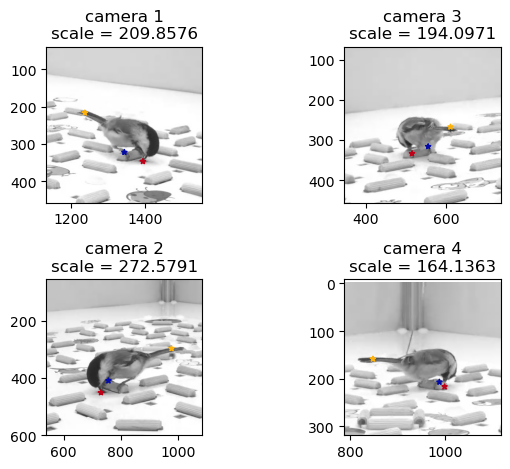

In [12]:
''' plot a frame to check output '''
ex_frame = 12
# fig params
f, ax = plt.subplots(n_cams//2, 2)
colors = ['xkcd:scarlet', 'xkcd:cobalt blue', 'xkcd:saffron']
node_idx = np.asarray([0, 14, 6]) # topBeak, rightFoot, tipTail
# x_idx = np.full(node_idx.shape[0], 0)
# y_idx = np.full(node_idx.shape[0], 1)
# plot for each camera
for n_cam in range(n_cams):
    # get subplot index
    if n_cam < n_cams//2:
        r = n_cam
        c = 0
    else:
        r = n_cam - n_cams//2
        c = 1
    # label example keypoints
    while np.isnan(np.sum(labels[ex_frame])):
        ex_frame += 1
    ax[r, c].imshow(all_cams[n_cam][:, :, :, ex_frame], cmap='gray')
    ax[r, c].scatter(all_labels[ex_frame, n_cam, node_idx, 0],
                     all_labels[ex_frame, n_cam, node_idx, 1],
                     c=colors, marker='*', s=15)

    # crop around bird
    centroid = all_centroids[ex_frame, n_cam]
    cam_scale = w3d * all_scales[ex_frame, n_cam]
    ax[r, c].set_title(f'camera {n_cam + 1}\nscale = {np.round(cam_scale, 4)}')
    ax[r, c].set_xlim([centroid[0] - cam_scale, centroid[0] + cam_scale])
    ax[r, c].set_ylim([centroid[1] + cam_scale, centroid[1] - cam_scale])
plt.tight_layout()
plt.show()

In [13]:
''' concatenate across camera views, crop and resize frames '''
label_data = [] # shape (total_frames, n_nodes, 2)
image_data = [] # shape (total_frames, ds_h, ds_w, RGB) from (ds_h,ds_w,RGB,total_frames)

for n_cam in range(n_cams):
    images = np.transpose(all_cams[n_cam], axes=[3, 0, 1, 2])
    labels = all_labels[:, n_cam]
    scales = all_scales[:, n_cam]
    centroids = all_centroids[:, n_cam]
    n_frames = labels.shape[0]
    for f in range(n_frames):
        if np.isfinite(labels[f].sum()):
            body_ctr = centroids[f]  # rough x-y body coords as in comNet
            half_width = np.round(w3d * scales[f])
            crop_img, min_ind, crop_scale = crop_from_com(images[f],
                                                          body_ctr,
                                                          half_width,
                                                          crop_size)
            crop_ann = (labels[f] - min_ind) * crop_scale
            image_data.append(crop_img)
            label_data.append(crop_ann)
label_data = np.stack(label_data, axis=0)
image_data = np.stack(image_data, axis=0)
np.save(training_vid_path, image_data)

In [14]:
# convert into a SLP project file
create_slp_project(vid_path=training_vid_path,
                   skeleton_file=skeleton_file,
                   keypoints=label_data,
                   slp_labels_file=slp_project_path)

rightEye is already symmetric with Node(name='leftEye', weight=1.0).
rightWing is already symmetric with Node(name='leftWing', weight=1.0).
rightAnkle is already symmetric with Node(name='leftAnkle', weight=1.0).
rightFoot is already symmetric with Node(name='leftFoot', weight=1.0).
